In [235]:
import sys

import matplotlib.pyplot as plt
import torch
from iopath.common.file_io import PathManager
from iopath.fb.manifold import ManifoldPathHandler


sys.path.insert(0, "fbcode/ar_sharing/body_tracking_3d/models/hmr/")

pathmgr = PathManager()
pathmgr.register_handler(ManifoldPathHandler(), allow_override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
seq = "downtown_runForBus_01_0"
f_name = f"sample_3dpw_test_seq_{seq}__hmr_coco_all.pth"
remote_path = f"manifold://xr_body/tree/personal/andreydavydov/3dpw_seq_for_tests/{f_name}"

seq = torch.load(pathmgr.get_local_path(remote_path))

num_frames = 339
for k in seq:
    seq[k] = seq[k][:num_frames]
seq.keys()

I0908 042715.986 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/3dpw_seq_for_tests/sample_3dpw_test_seq_downtown_runForBus_01_0__hmr_coco_all.pth was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/3dpw_seq_for_tests/sample_3dpw_test_seq_downtown_runForBus_01_0__hmr_coco_all.pth


dict_keys(['img', 'theta', 'kp_2d', 'kp_3d', 'pred_rotmat', 'pred_shape', 'pred_camera', 'instance_id'])

# gt shape is constant, but we can't get this information

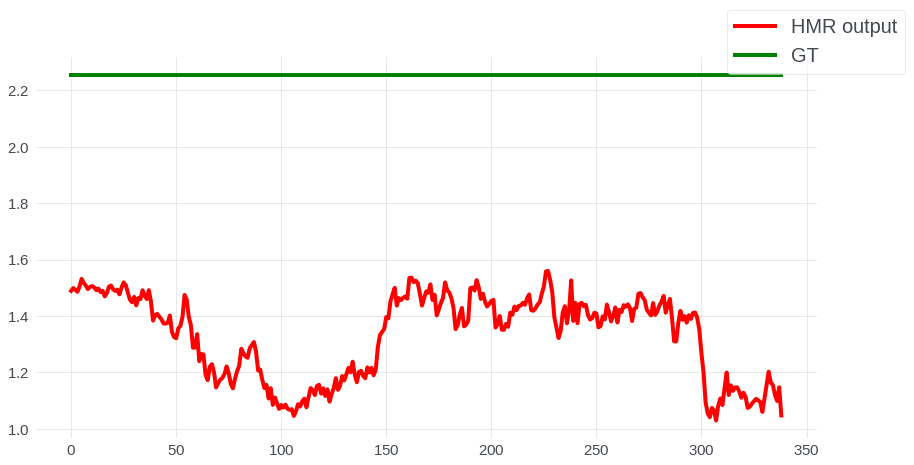

In [38]:
shape = seq["pred_shape"]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.plot(shape.norm(dim=-1), c='red', label='HMR output')

shape_gt = seq["theta"][:, 75:]
ax.plot(shape_gt.norm(dim=-1), c='green', label='GT')

fig.legend(fontsize=20)
fig.patch.set_facecolor("white")

In [40]:
from src.functional import smpl
device = 'cuda'
smpl_model = smpl.get_smpl_model("extra", device=device)

I0908 042720.530 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/eft/extradata/smpl/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/eft/extradata/smpl/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl


I0908 042720.635 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/eft/extradata/data_from_spin/J_regressor_extra.npy was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/eft/extradata/data_from_spin/J_regressor_extra.npy


# write videos:

In [41]:
from src.functional import smpl
from src.utils.video_utils import write_video

device = "cuda"
smpl_model = smpl.get_smpl_model("h36m", device=device)
fps = 20
batch_size = 339
img_size = torch.tensor([224, 224]).repeat(batch_size, 1).to(device)
faces = smpl_model.faces.astype(int)

import os

video_dir = "/tmp/videos_seq_optim/"
os.makedirs(video_dir, exist_ok=True)

import numpy as np


def render_verts_only(verts, faces, device, img_size=512):
    verts_mean = verts.copy().mean(axis=0, keepdims=True)
    verts -= verts_mean
    scale = 1  # 0.8
    verts *= scale
    verts = (verts + 1) / 2 * img_size
    # img = np.zeros((img_size,img_size,3))
    img = (255 * np.ones((img_size, img_size, 3))).astype("uint8")
    blend = render_mesh_onto_image(img, verts, faces, device)
    return blend

I0908 042723.726 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/eft/extradata/smpl/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/eft/extradata/smpl/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl


I0908 042723.826 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/eft/extradata/data_from_spin/J_regressor_h36m.npy was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/eft/extradata/data_from_spin/J_regressor_h36m.npy


## original:

In [42]:
from src.datasets.datasets_common import UNNORMALIZE

seq = "downtown_runForBus_01_0"
f_name = f"sample_3dpw_test_seq_{seq}__hmr_coco_all.pth"
remote_path = f"manifold://xr_body/tree/personal/andreydavydov/3dpw_seq_for_tests/{f_name}"

seq = torch.load(pathmgr.get_local_path(remote_path))

num_frames = 339
for k in seq:
    seq[k] = seq[k][:num_frames]

img_orig = UNNORMALIZE(seq["img"]).permute(0, 2, 3, 1).numpy().astype("uint8")

write_video(img_orig, f"{video_dir}orig.mp4", fps=fps)

I0908 042726.958 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/3dpw_seq_for_tests/sample_3dpw_test_seq_downtown_runForBus_01_0__hmr_coco_all.pth was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/3dpw_seq_for_tests/sample_3dpw_test_seq_downtown_runForBus_01_0__hmr_coco_all.pth


Video is saved to '/tmp/videos_seq_optim/orig.mp4'


# prediction of the HMR, w/o optimization

In [30]:
from src.utils.vis_utils import render_mesh_onto_image
from src.utils.img_utils import convert_norm_points_to_bbox
from src.models.seq_optim import get_smpl_out

rotmat_init = seq["pred_rotmat"].to(device)
shape_init = seq["pred_shape"].to(device)
camera_init = seq["pred_camera"].to(device)

_, _, verts_all = get_smpl_out(shape_init, rotmat_init, camera_init, smpl_model, pose2rot=False)

scale, trans = camera_init[:,0], camera_init[:, 1:]
verts_all_bbox = convert_norm_points_to_bbox(verts_all, scale, trans, img_size)

In [31]:
frames_out = []
for i in range(len(verts_all_bbox)):
    verts = verts_all_bbox[i].cpu().numpy()
    img = img_orig[i]
    blend = render_mesh_onto_image(img, verts, faces, device)
    frames_out.append(blend)

write_video(frames_out, f"{video_dir}pred_hmr.mp4", fps=fps)


frames_out = []
for i in range(len(verts_all)):
    verts = verts_all[i].cpu().numpy()
    blend = render_verts_only(verts, faces, device)
    frames_out.append(blend)

write_video(frames_out, f"{video_dir}verts_pred_hmr.mp4", fps=fps)

Video is saved to '/tmp/videos_seq_optim/pred_hmr.mp4'


Video is saved to '/tmp/videos_seq_optim/verts_pred_hmr.mp4'


# Ours. Optimization, smoothing Shape and j3d

In [220]:
ckpt_names = [
    "grid__shape_0.0_pose_1_f30",
]

for full_name in ckpt_names:
    ckpt_dir = f"manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/{full_name}"

    ckpt = torch.load(pathmgr.get_local_path(f"{ckpt_dir}/ckpt.pth"), map_location='cpu')['seqOpt_state_dict']

    pose = ckpt["pose"].to(device)
    shape = ckpt["shape"].to(device)
    camera = ckpt["camera"].to(device)

    _, _, verts_all = get_smpl_out(shape, pose, camera, smpl_model, pose2rot=True)
    scale, trans = camera[:,0], camera[:, 1:]
    verts_all_bbox = convert_norm_points_to_bbox(verts_all, scale, trans, img_size)

    frames_out = []
    for i in range(len(verts_all_bbox)):
        verts = verts_all_bbox[i].cpu().numpy()
        img = img_orig[i]
        blend = render_mesh_onto_image(img, verts, faces, device)
        frames_out.append(blend)

    write_video(frames_out, f"{video_dir}Ours_temp_smoothing_{full_name}.mp4", fps=fps)

    frames_out = []
    for i in range(len(verts_all)):
        verts = verts_all[i].cpu().numpy()
        blend = render_verts_only(verts, faces, device)
        frames_out.append(blend)

    write_video(frames_out, f"{video_dir}verts_Ours_temp_smoothing_{full_name}.mp4", fps=fps)

I0908 063834.681 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_0.0_pose_1_f30/ckpt.pth was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_0.0_pose_1_f30/ckpt.pth


/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/110b607930331a92/ar_sharing/body_tracking_3d/models/hmr/__bento_kernel_body_tracking__/bento_kernel_body_tracking#link-tree/pytorch3d/renderer/mesh/textures.py:324: PendingDeprecationWarning:

Textures class is deprecated,
        use TexturesUV, TexturesAtlas, TexturesVertex instead.
        Textures class will be removed in future releases.



Video is saved to '/tmp/videos_seq_optim/Ours_temp_smoothing_grid__shape_0.0_pose_1_f30.mp4'


Video is saved to '/tmp/videos_seq_optim/verts_Ours_temp_smoothing_grid__shape_0.0_pose_1_f30.mp4'


# acceleration


In [236]:
class Acceleration(torch.nn.Module):
    def __init__(self):
        super(Acceleration, self).__init__()

    def forward(self, joints):
        velocities = joints[1:] - joints[:-1]
        acceleration = velocities[1:] - velocities[:-1]
        acceleration_normed = torch.linalg.norm(acceleration, dim=2)
        return acceleration_normed # B x N

In [273]:
from src.models.seq_optim import get_smpl_out, SeqModel

### gt
seqOpt = SeqModel(
    "manifold://xr_body/tree/personal/andreydavydov/3dpw_seq_for_tests/sample_3dpw_test_seq_downtown_runForBus_01_0__hmr_coco_all.pth",
    339,
)
seqOpt = seqOpt.to(device)
theta = seqOpt.orig_seq["theta"].to(device)
gt_smpl_pose, gt_smpl_shape = theta[:, 3:75], theta[:, 75:]

smpl_model_14 = smpl.get_smpl_model("h36m", device=device)
gt_out = smpl_model_14(
    betas=gt_smpl_shape,
    body_pose=gt_smpl_pose[:, 3:],
    global_orient=gt_smpl_pose[:, :3],
)
verts_gt, j3d_gt = gt_out.vertices, gt_out.joints
accel_verts_gt = Acceleration()(verts_gt).cpu() * 1000
accel_j3d_gt = Acceleration()(j3d_gt).cpu() * 1000

j2d_init, j3d_init, verts_init = seqOpt.forward_with_init(smpl_model_14)
accel_verts_init = Acceleration()(verts_init).cpu() * 1000
accel_j3d_init = Acceleration()(j3d_init).cpu() * 1000

accel = [
    accel_j3d_gt,
    accel_j3d_init,
]

I0909 014348.527 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/3dpw_seq_for_tests/sample_3dpw_test_seq_downtown_runForBus_01_0__hmr_coco_all.pth was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/3dpw_seq_for_tests/sample_3dpw_test_seq_downtown_runForBus_01_0__hmr_coco_all.pth


I0909 014348.889 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/eft/extradata/smpl/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/eft/extradata/smpl/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl


I0909 014348.993 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/eft/extradata/data_from_spin/J_regressor_h36m.npy was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/eft/extradata/data_from_spin/J_regressor_h36m.npy


I0909 014350.635 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_1_pose_1_f30/ckpt.pth was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_1_pose_1_f30/ckpt.pth


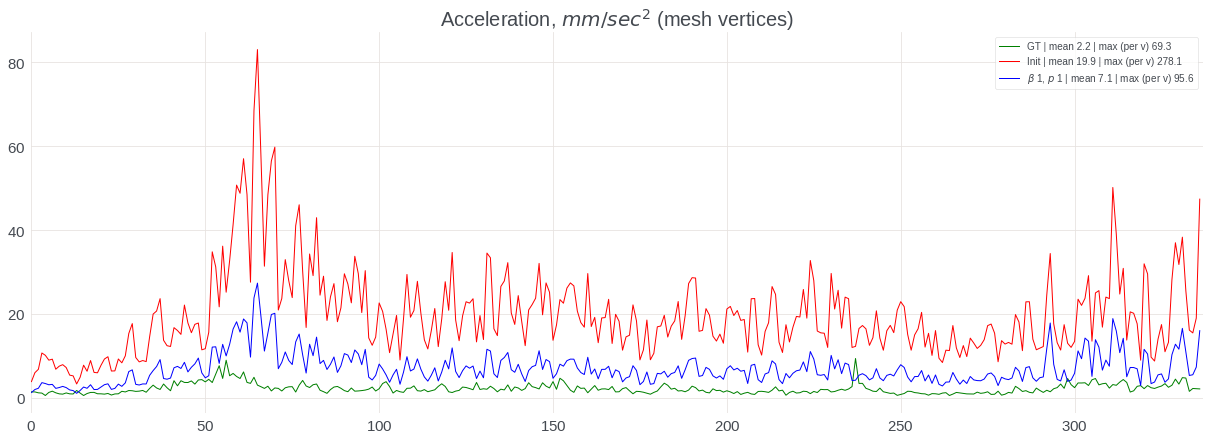

In [274]:
fig, ax = plt.subplots(1, 1, figsize=(21, 7))
colors = {"gt": "green", "init": "red"}
other_colors = ["blue", "orange", 'majenta']
ax.plot(
    accel_verts_gt.mean(dim=1),
    label=f"GT | mean {float(accel_verts_gt.mean()):.1f} | max (per v) {float(accel_verts_gt.max()):.1f}",
    c=colors["gt"],
    linewidth=1,
)
# ax.plot(
#     accel_j3d_gt.mean(dim=1),
#     label=f"j3d GT | mean {float(accel_j3d_gt.mean()):.1f} | max {float(accel_j3d_gt.max()):.1f}",
#     c=colors["gt"],
#     linestyle="--",
#     linewidth=1,
# )

ax.plot(
    accel_verts_init.mean(dim=1),
    label=f"Init | mean {float(accel_verts_init.mean()):.1f} | max (per v) {float(accel_verts_init.max()):.1f}",
    c=colors["init"],
    linewidth=1,
)
# ax.plot(
#     accel_j3d_init.mean(dim=1),
#     label=f"j3d 0 | mean {float(accel_j3d_init.mean()):.1f} | max {float(accel_j3d_init.max()):.1f}",
#     c=colors["init"],
#     linestyle="--",
#     linewidth=1,
# )


ckpt_names = {
    # r"$\beta$ 10, $p$ 0.3":"grid__shape_10_pose_0.3_f30",
    r"$\beta$ 1, $p$ 1":"grid__shape_1_pose_1_f30",
    # r"$\beta$ 0, $p$ 1":"grid__shape_0.0_pose_1_f30",
}

for i, (name, full_name) in enumerate(ckpt_names.items()):
    ckpt_dir = f"manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/{full_name}"
    ckpt = torch.load(pathmgr.get_local_path(f"{ckpt_dir}/ckpt.pth"), map_location='cpu')['seqOpt_state_dict']

    ### pred
    pose = ckpt["pose"].to(device)
    shape = ckpt["shape"].to(device)
    camera = ckpt["camera"].to(device)
    _, j3d, verts = get_smpl_out(shape, pose, camera, smpl_model, pose2rot=True)

    accel_verts_pred = Acceleration()(verts).cpu() * 1000
    accel_j3d_pred = Acceleration()(j3d).cpu() * 1000

    # accel[f"verts_pred_{name}"] = accel_verts_pred
    accel.append(accel_j3d_pred)

    ax.plot(
        accel_verts_pred.mean(dim=1),
        label=f"{name} | mean {float(accel_verts_pred.mean()):.1f} | max (per v) {float(accel_verts_pred.max()):.1f}",
        c=other_colors[i],
        linewidth=1,
    )
    # ax.plot(
    #     accel_j3d_pred.mean(dim=1),
    #     label=f"j3d pred | mean {float(accel_j3d_pred.mean()):.1f} | max {float(accel_j3d_pred.max()):.1f}",
    #     c=other_colors[i],
    #     linestyle="--",
    #     linewidth=1,
    # )

ax.legend()
ax.set_xlim((0,337))
ax.set_title(r"Acceleration, $mm/sec^2$ (mesh vertices)", fontsize=20)
fig.patch.set_facecolor("white")


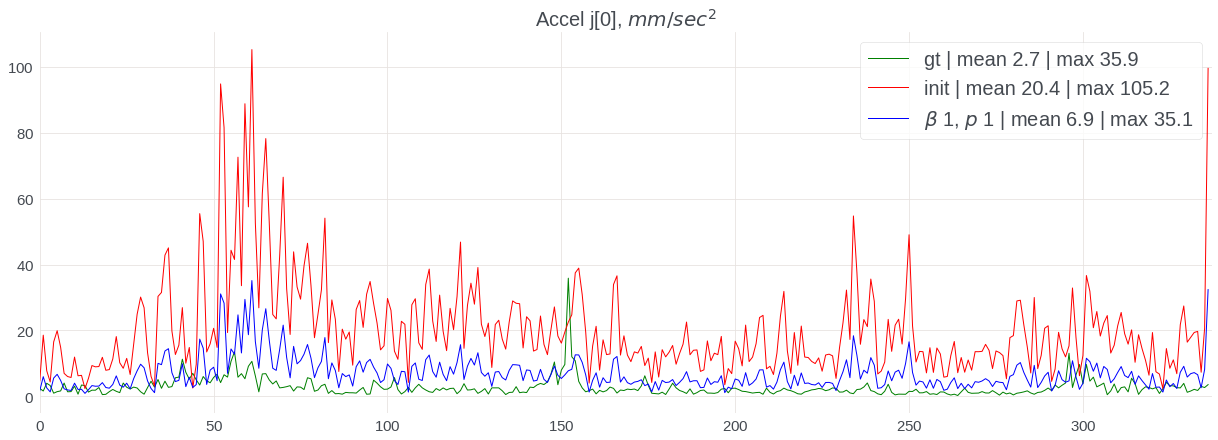

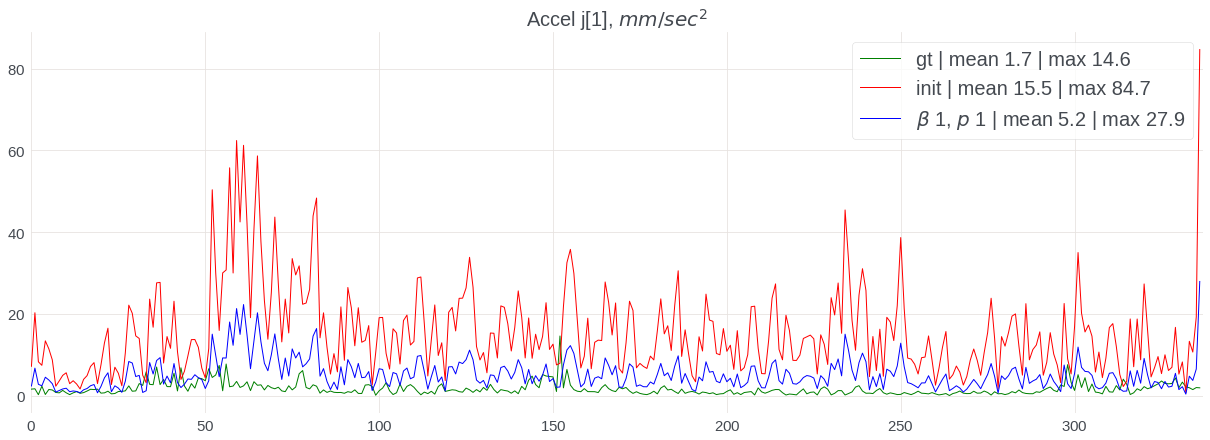

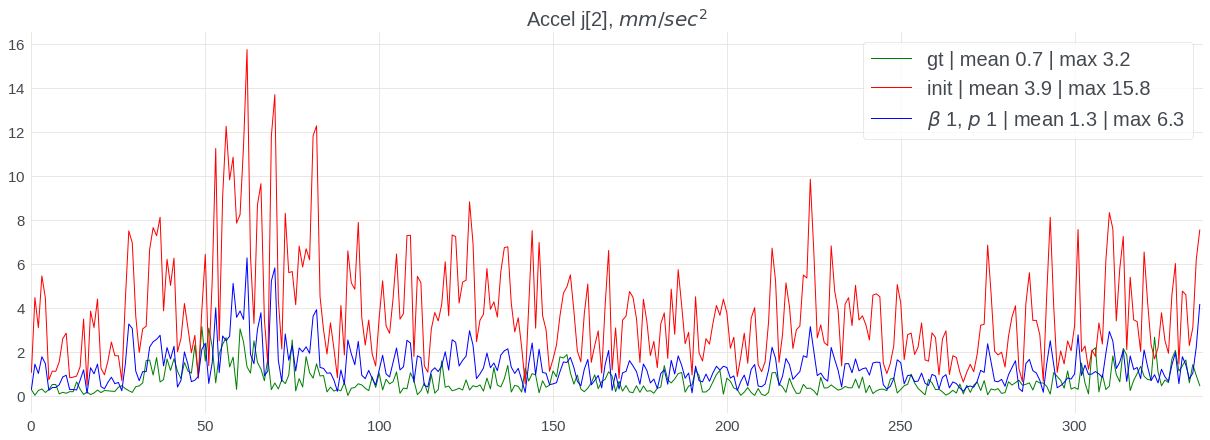

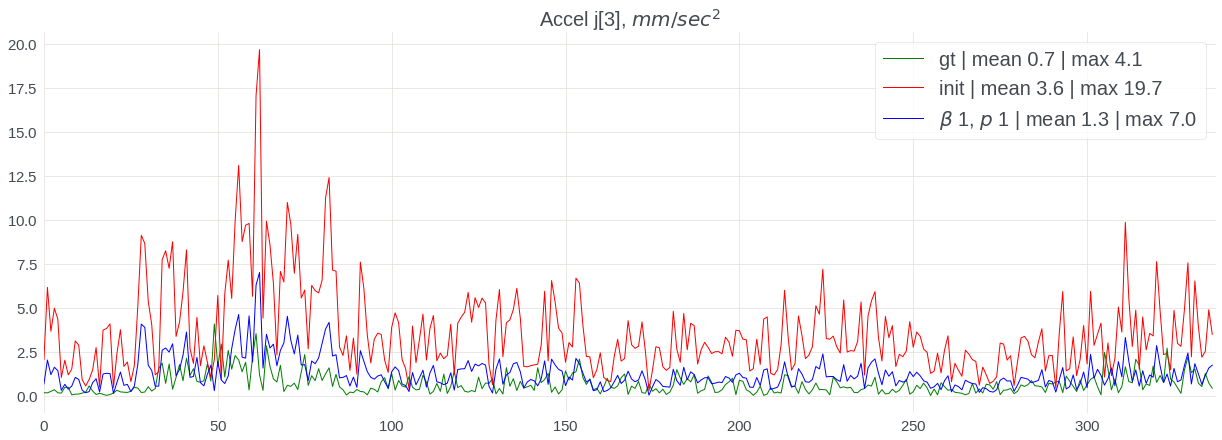

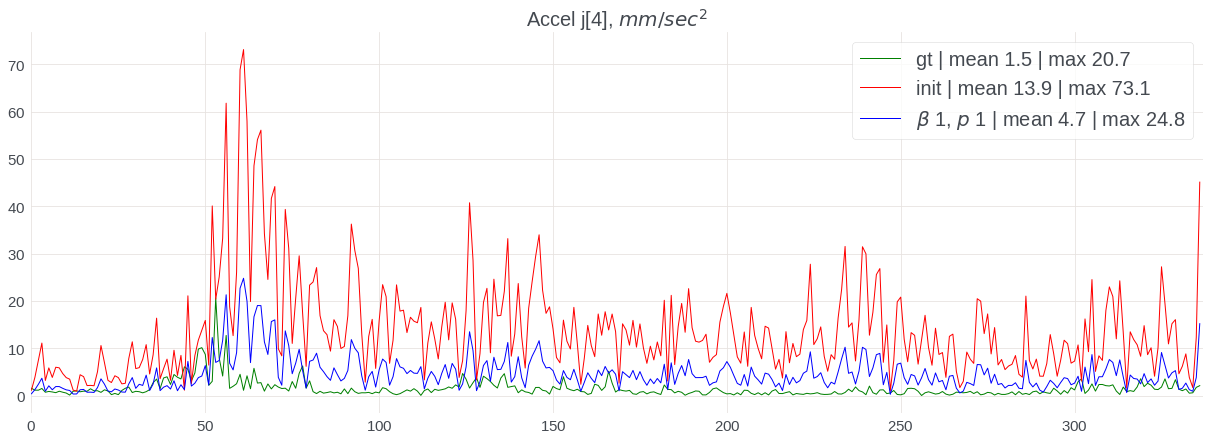

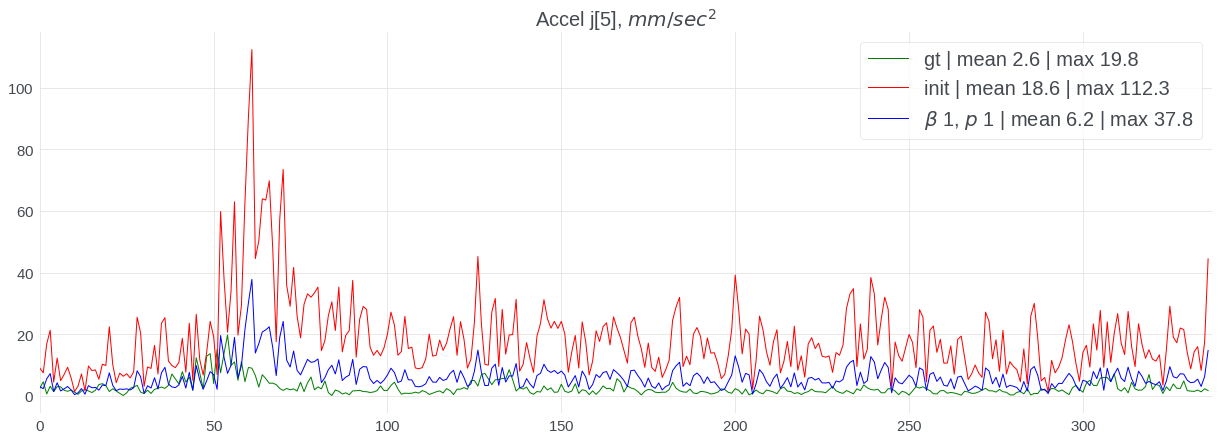

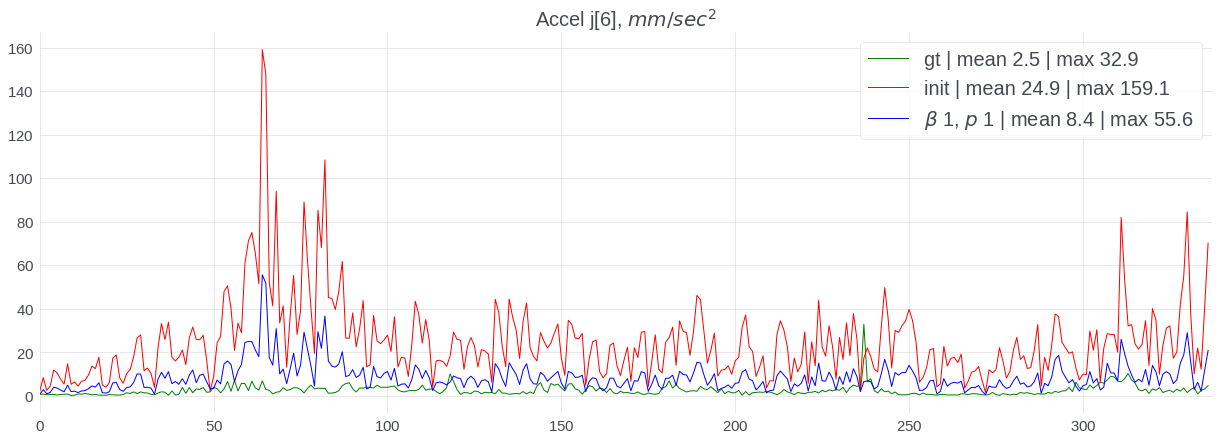

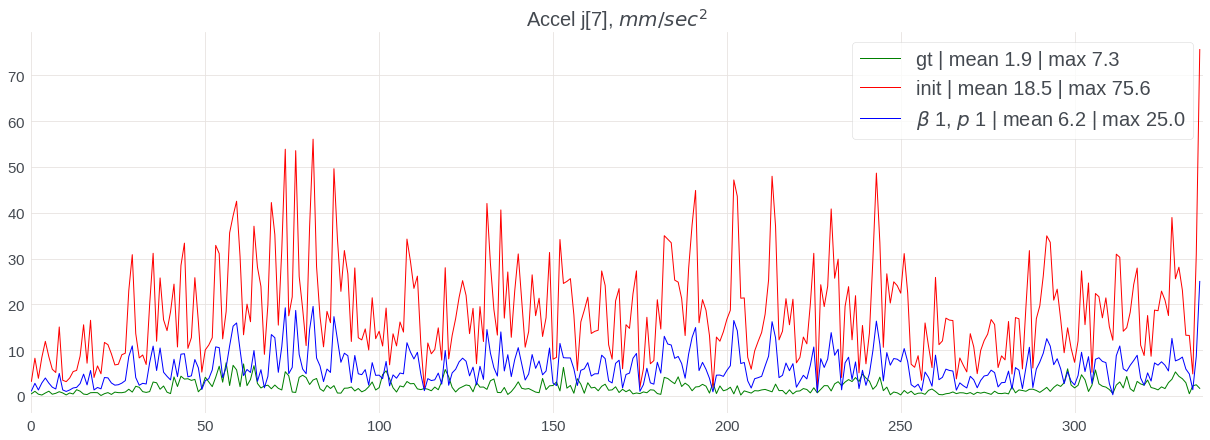

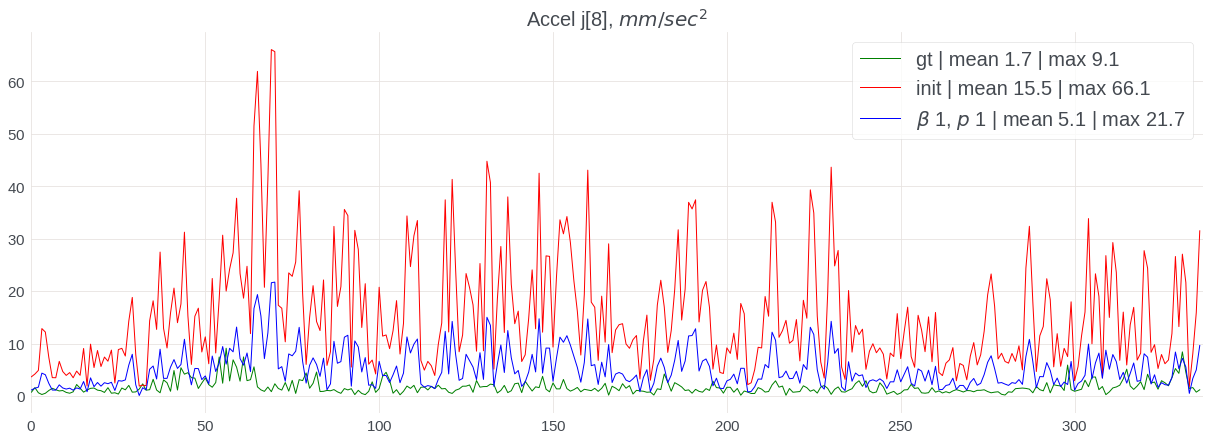

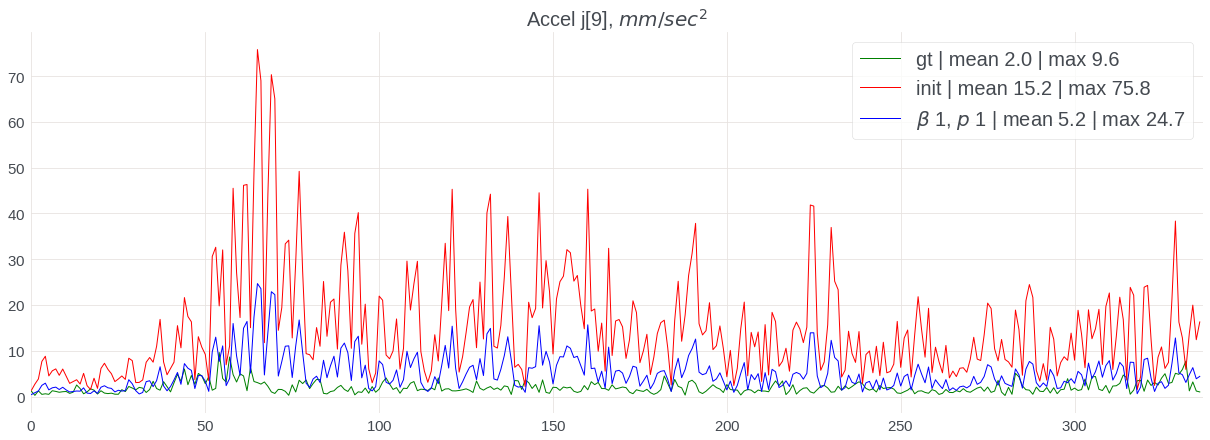

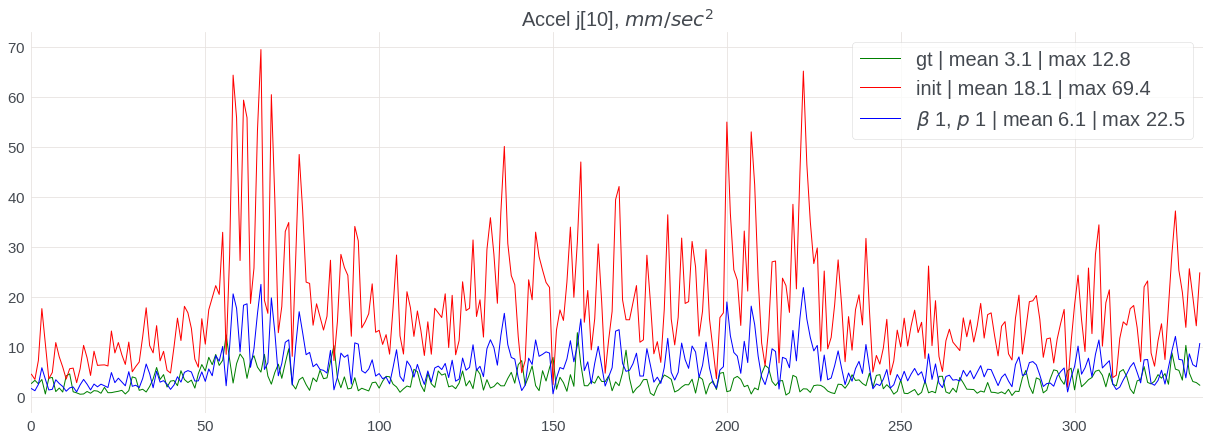

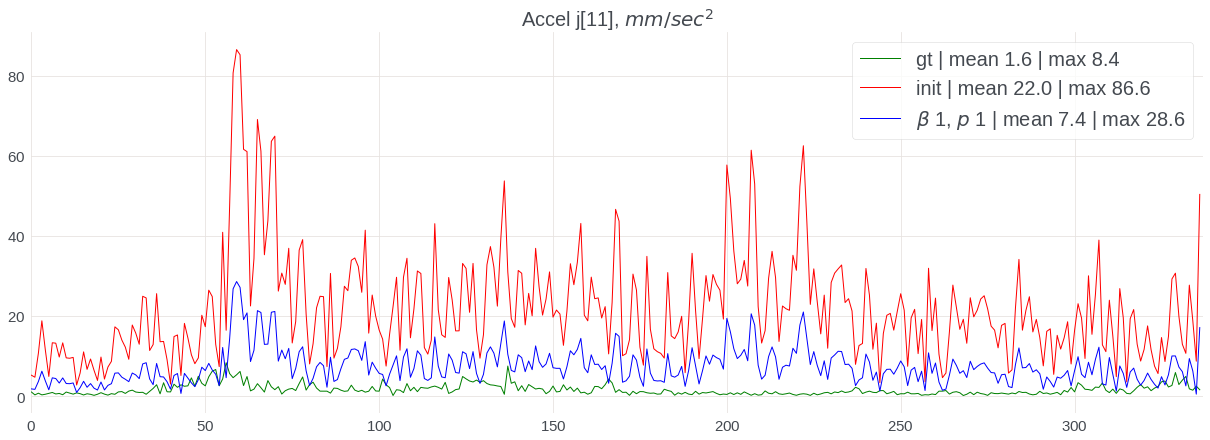

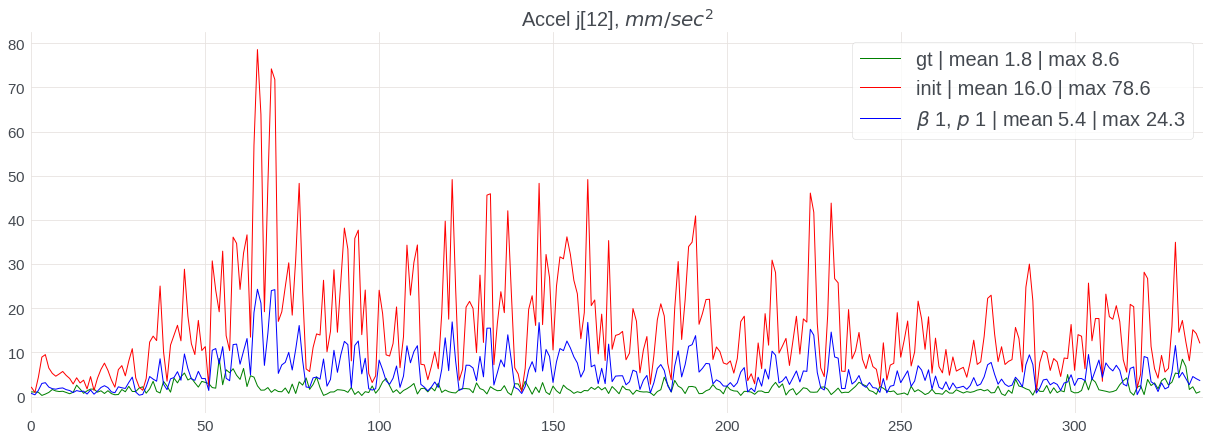

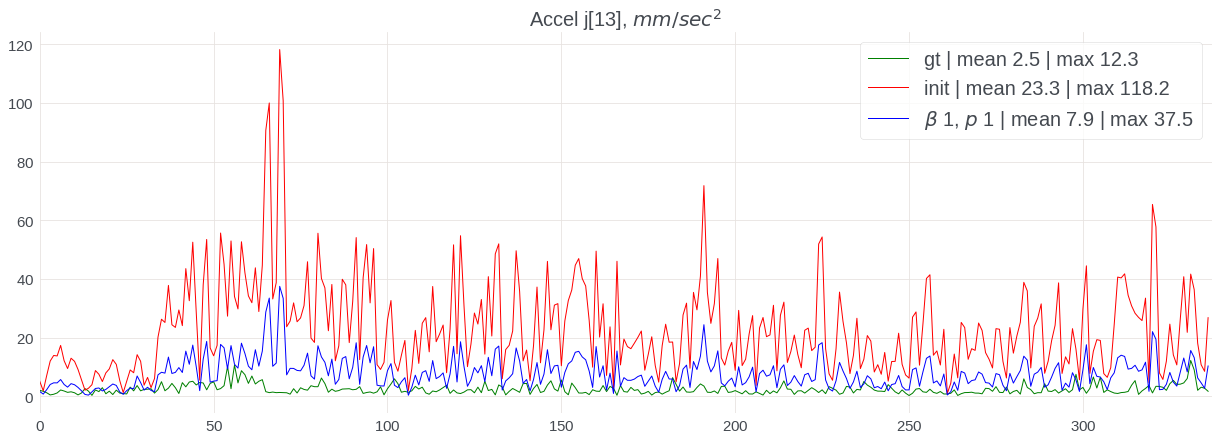

In [296]:
save_dir = "/tmp/joints14_accel"
os.makedirs(save_dir, exist_ok=True)
for joint in range(14):
    fig, ax = plt.subplots(1, 1, figsize=(21, 7))
    colors = ["green", "red", "blue"]
    names = ["gt", "init", r"$\beta$ 1, $p$ 1"]
    for i, acceleration in enumerate(accel):
        accel_j = acceleration[:, joint]
        ax.plot(
            accel_j,
            label=f"{names[i]} | mean {float(accel_j.mean()):.1f} | max {float(accel_j.max()):.1f}",
            c=colors[i],
            linewidth=1,
        )

    ax.legend(fontsize=20)
    ax.set_xlim((0, 337))
    ax.set_title(f"Accel j[{joint}], " + r"$mm/sec^2$", fontsize=20)
    fig.patch.set_facecolor("white")

    fig.savefig(f"{save_dir}/fig_joint_{joint:02d}.png")

In [314]:
pose = torch.zeros((1, 24, 3)).to(device)
shape = torch.zeros((1, 10)).to(device)
camera = torch.zeros((1, 3)).to(device)
_, j3d, verts = get_smpl_out(shape, pose, camera, smpl_model, pose2rot=True)
j3d = j3d[0].cpu().numpy()
verts = verts[0].cpu().numpy()

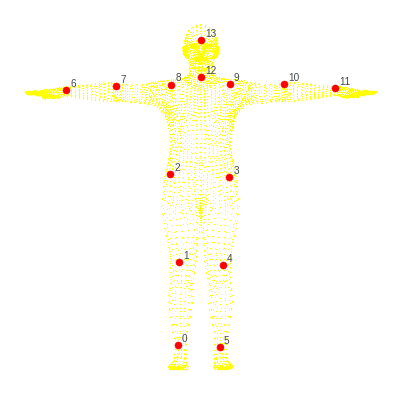

In [330]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(verts[:,0], verts[:,1], c='yellow', s=0.5)
ax.scatter(j3d[:,0], j3d[:,1], c='red', s=50)
ax.set_aspect("equal")

for i, joint in enumerate(j3d):
    ax.annotate(i, joint[:2]+0.02)

ax.set_axis_off()
fig.patch.set_facecolor("white")
    
fig.savefig(f"{save_dir}/joints_map.png")

I0909 053527.687 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_1_pose_1_f30/ckpt.pth was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_1_pose_1_f30/ckpt.pth


I0909 053527.692 manifold.py:1435] URL manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_0.0_pose_1_f30/ckpt.pth was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_0.0_pose_1_f30/ckpt.pth


Text(0.5, 1.0, '$\\|\\beta\\|_2$')

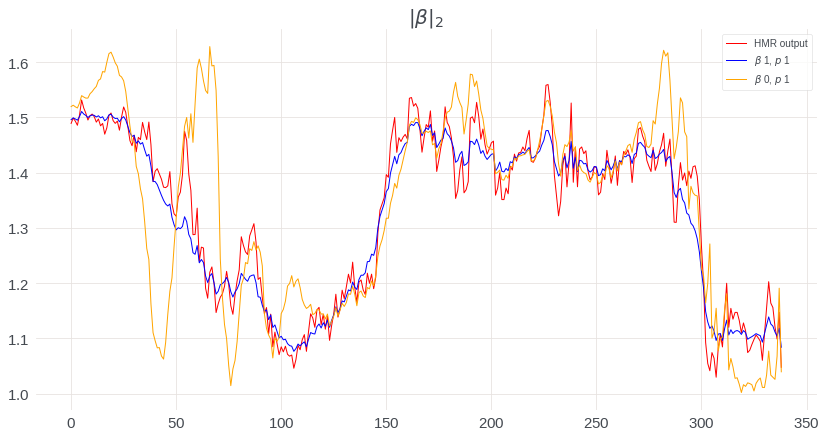

In [332]:
## plot shapes

ckpt_names = {
    # r"$\beta$ 10, $p$ 0.3":"grid__shape_10_pose_0.3_f30",
    r"$\beta$ 1, $p$ 1":"grid__shape_1_pose_1_f30",
    r"$\beta$ 0, $p$ 1":"grid__shape_0.0_pose_1_f30",
}

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.plot(shape_init.cpu().norm(dim=-1), c='red', label='HMR output', linewidth=1)
# ax.plot(gt_smpl_shape.clone().cpu().norm(dim=-1), c='green', label='GT')

for i, (name, full_name) in enumerate(ckpt_names.items()):
    ckpt_dir = f"manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/{full_name}"
    ckpt = torch.load(pathmgr.get_local_path(f"{ckpt_dir}/ckpt.pth"), map_location='cpu')['seqOpt_state_dict']
    shape = ckpt["shape"]
    ax.plot(shape.norm(dim=-1), label=name, linewidth=1, c=other_colors[i])

ax.legend()
fig.patch.set_facecolor("white")
ax.set_title(r"$\|\beta\|_2$", fontsize=20)